ANOVA for School Demand

In [48]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
%matplotlib inline


In [49]:
pip install xlrd==1.2.0

Note: you may need to restart the kernel to use updated packages.


In [50]:
# load data file (note that we are specifying a separator other than the default comma in read_csv, the symbol for "tab" is "\t")
df = pd.read_excel('Enrollment Rate.xlsx')
df

,School,2016,2017,2018,2019,2020
0,ACORN Woodland Elementa,0.769,0.709,1.132,0.980,1.021
1,Allendale Elementary,0.197,0.311,0.423,0.389,0.446
2,Alliance Academy,0.548,0.582,0.771,NaN,NaN
3,Bella Vista Elementary,0.318,0.241,0.385,0.376,0.635
4,Bret Harte Middle,0.581,0.444,0.521,0.442,0.469
...,...,...,...,...,...,...
75,Thornhill Elementary,1.118,1.242,1.229,1.196,1.333
76,United for Success Acad,0.477,0.388,0.391,0.626,0.545
77,Urban Promise Academy,0.929,0.800,1.040,1.246,0.928
78,West Oakland Middle,0.975,0.699,0.768,0.759,0.520


In [51]:
hsdf = pd.read_excel('Demand_School.xlsx')
hsdf 

,Year,Castlemont_High,Fremont_High,Oakland_High,Oakland_Technical_High
0,2016,0.502,0.363,0.510,2.049
1,2017,0.433,0.229,0.673,2.026
2,2018,0.685,0.492,0.837,2.446
3,2019,0.397,0.504,0.806,2.303
4,2020,0.673,0.708,0.853,2.402


If we look at the dataframe we just loaded, we can see that we have one control group (no fertilizer) and three different fertilizer treatments.

We can make a boxplot to visualize our data and their distributions.

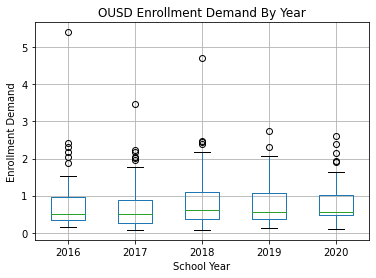

In [52]:
# Using boxplot, we can start to visually see differences between the treatment groups
df.boxplot()

# Add labels
plt.xlabel('School Year')
plt.ylabel('Enrollment Demand')
plt.title('OUSD Enrollment Demand By Year');

In [39]:
hsdf= hsdf.drop('Year', axis=1)

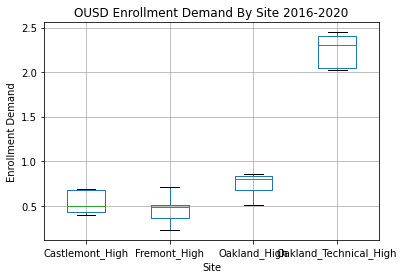

In [40]:
hsdf.boxplot()

# Add labels
plt.xlabel('Site')
plt.ylabel('Enrollment Demand')
plt.title('OUSD Enrollment Demand By Site 2016-2020');

**State our null and alternative hypothesis:**

$H_0$: All groups have the same central mean

$H_1$: The means are different from each other

We want 95% confidence, so choose $\alpha = 0.05$

In this case, we perform a one-way (also called one-factor) ANOVA to determine whether our null hypothesis ($H_0$) is true or not. 

In [41]:
# stats f_oneway functions takes the groups as input and returns an F and P-value
fvalue, pvalue = stats.f_oneway(hsdf['Castlemont_High'], hsdf['Fremont_High'], hsdf['Oakland_High'], hsdf['Oakland_Technical_High'])

# print the results
print("F-statistic = {}".format( np.round(fvalue,2)))
print("p = {}".format( pvalue ))

F-statistic = 129.48
p = 1.96794503576627e-11


Our p-value is smaller than our chosen $\alpha$, so in this case we can reject the null hypothesis.

In [44]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

In [45]:
# reshape the d dataframe suitable for statsmodels package 
df_reshaped = pd.melt(hsdf.reset_index(), id_vars=['index'], value_vars=['Castlemont_High', 'Fremont_High', 'Oakland_High', 'Oakland_Technical_High'])

# replace column names
df_reshaped.columns = ['index', 'schools', 'value']

# Ordinary Least Squares (OLS) model
model = ols('value ~ C(schools)', data=df_reshaped).fit()
anova_table = sm.stats.anova_lm(model, typ=2)

# display the results table
anova_table

,sum_sq,df,F,PR(>F)
C(schools),10.630573,3.0,129.475613,1.967945e-11
Residual,0.437892,16.0,NaN,NaN


In [46]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd

In [47]:
# perform multiple pairwise comparison (Tukey HSD)
m_comp = pairwise_tukeyhsd(endog=df_reshaped['value'], groups=df_reshaped['schools'], alpha=0.05)

# display the results table
print(m_comp)

            Multiple Comparison of Means - Tukey HSD, FWER=0.05             
     group1             group2         meandiff p-adj   lower  upper  reject
----------------------------------------------------------------------------
Castlemont_High           Fremont_High  -0.0788 0.8646 -0.3782 0.2206  False
Castlemont_High           Oakland_High   0.1978 0.2708 -0.1016 0.4972  False
Castlemont_High Oakland_Technical_High   1.7072  0.001  1.4078 2.0066   True
   Fremont_High           Oakland_High   0.2766 0.0755 -0.0228  0.576  False
   Fremont_High Oakland_Technical_High    1.786  0.001  1.4866 2.0854   True
   Oakland_High Oakland_Technical_High   1.5094  0.001    1.21 1.8088   True
----------------------------------------------------------------------------


The "reject" column in this table shows us that all of the school site demand rates are different from the control (reject=True, we can reject the null hypothesis), and that treatments F2 and F3 are different from each (reject=True) other but not from F1 (reject=False).

 Note that the lower and upper ranges shown in the boxplot suggest a real difference if the 95% confidence range does not include 0.  (If it includes 0, then there's a chance that there's really no difference at all.)

